# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 读入日线数据

### 读入日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20240630.feather')

### 计算调仓日

In [3]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start='2019-08-01', end=trade_date[-1]+pd.DateOffset(months=1), freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

### 计算每两个调仓日之间的收益

In [4]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_temp(ret):
    return (1 + ret).prod() - 1

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

price_adj = (
    price_1d[(price_1d['date'] >= '2019-08-01') & (price_1d['date'] <= '2024-12-31')]
        .groupby(['issue', 'year_mon'])[['preclose', 'close']]
        .apply(ret_acc)
        .reset_index()
)
price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

### 剔除股票

In [5]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[['issue', 'date', 'ret_next']]

## 市值行业中性化

### 测试数据

In [7]:
N_connect_num = feather.read_dataframe('../data/N_connect/N_connect_num.feather')

### 读入申万行业和市值

In [8]:
# sd.auth('*', '*')
# issues = price_1d['issue'].sort_values().unique()
# market_cap = sd.get_ricequant_factor(
#     issues,
#     start_date='2019-08-01',
#     end_date='2024-12-31',
#     fields=['market_cap_3']
# )
# market_cap = market_cap.reset_index()
# market_cap = market_cap.rename(columns={'market_cap_3': 'market_cap'})
# market_cap['date'] = pd.to_datetime(market_cap['date'])
# feather.write_dataframe(market_cap, '../data/market_cap.feather')

In [9]:
industry = feather.read_dataframe('../data/industry_classes.feather')
market_cap = feather.read_dataframe('../data/market_cap.feather')

### 行业中性化

In [49]:
factor_col = 'N_connect'

factor = pd.merge(
    N_connect_num,
    price_adj[['issue', 'date']],
    on=['issue', 'date'],
    how='inner'
)
factor = pd.merge(
    factor,
    industry[['issue', 'date', 'L1']],
    on=['issue', 'date'],
    how='inner'
)
indus_mean = factor.groupby('L1')[factor_col].mean()
indus_mean = indus_mean.rename('indus_mean')
factor = pd.merge(
    factor,
    indus_mean,
    on='L1',
    how='left'
)
factor['indus_factor'] = factor['N_connect'] - factor['indus_mean']
factor = factor[['issue', 'date', factor_col, 'indus_factor']]

### 市值中性化

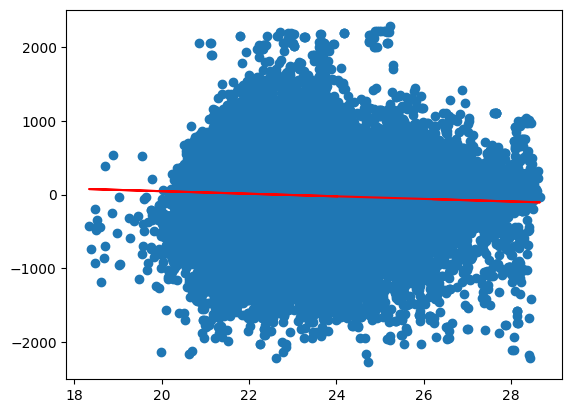

In [60]:
market_cap['log_market_cap'] = market_cap['market_cap'].apply(np.log)
factor2 = pd.merge(
    factor,
    market_cap,
    on=['issue', 'date'],
    how='left'
)
x = factor2['log_market_cap']
x = sm.add_constant(x)
y = factor2['indus_factor']
result = sm.OLS(y, x).fit()
factor2['neutral_factor'] = result.resid
plt.scatter(factor2['log_market_cap'], y)
plt.plot(factor2['log_market_cap'], result.fittedvalues, color='red')
plt.show()

In [57]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           indus_factor   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     821.5
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          2.33e-180
Time:                        15:39:44   Log-Likelihood:            -1.7537e+06
No. Observations:              242478   AIC:                         3.507e+06
Df Residuals:                  242476   BIC:                         3.508e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            396.1901     13.840     28.627      0.000     369.064     423.316
log_market_cap   -17.4757      0.610    -28.661      0.000     -18.671     -16.281
==============================================================================
Omnibus:                    16103.910   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67601.355
Skew:                          -0.197   Prob(JB):                         0.00
Kurtosis:                       5.557   Cond. No.                         463.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## IC 测试

In [11]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f.sort_values(['issue', 'date']),
        price_adj.sort_values(['issue', 'date']),
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col='N_connect', ret_col='ret_next')
    )
    return IC

## 分组测试

## 点度中心性回测

### 读入数据

In [12]:
N_connect_num = feather.read_dataframe('../data/N_connect/N_connect_num.feather')
N_connect_size = feather.read_dataframe('../data/N_connect/N_connect_size.feather')

### IC 测试

In [13]:
df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'IC_IR', 't', "max", 'min'])
IC_num = IC_calc(N_connect_num, factor_col='N_connect')
df_IC.loc[0]=[
        'N_connect_num',
        IC_num.mean(),
        IC_num.mean() / IC_num.std(),
        np.sqrt(len(IC_num)) * IC_num.mean() / IC_num.std(),
        IC_num.max(),
        IC_num.min()
    ]
IC_size = IC_calc(N_connect_size, factor_col='N_connect')
df_IC.loc[1]=[
        'N_connect_size',
        IC_size.mean(),
        IC_size.mean() / IC_size.std(),
        np.sqrt(len(IC_size)) * IC_size.mean() / IC_size.std(),
        IC_size.max(),
        IC_size.min()
    ]
df_IC

,factor,IC_mean,IC_IR,t,max,min
0,N_connect_num,0.014396,0.195837,1.491448,0.132223,-0.213333
1,N_connect_size,0.012861,0.161662,1.231179,0.185625,-0.195944


### 分组测试